# League of Legends Ward Correlation Analysis

**Name(s)**: Jacob Doan, Vanessa Feng

**Website Link**: (your website link)

In [192]:
# Add utils to system path so we can import from there
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'utils')))

# Required Imports
import pandas as pd
import numpy as np
from pathlib import Path

import plotly.express as px
pd.options.plotting.backend = 'plotly'

from dsc80_utils import * # Feel free to uncomment and use this.

# Additional Imports
import plotly.graph_objects as go
from scipy.stats import gaussian_kde

## Step 1: Introduction

**League of Legends (LoL)** is a highly strategic, team-based game in which two teams of five players compete to destroy the opposing team’s base. Success can be influenced not only on individual skill but also on factors like map control, resource management, and coordinated teamwork.

For this project, we are going to analyze match data from Oracle’s Elixir, a premier database for professional LoL esports stats, covering the 2024 competitive season. The dataset includes match outcomes and detailed statistics such as kills, deaths, assists, team gold, dragons secured, towers destroyed, and advanced vision metrics like wards placed and wards cleared.

Our primary research questions focus on the **impact of objective control and vision control on win rates**. For example, we wondered: How does objective control influence win rates? How much can vision control influence win rates? Are there particular metrics that are especially predictive of success? Eventually, we decided to explore the following question further:
**What is the optimal number of wards placed per minute (WPM) that maximizes a team’s probability of winning?**

In LoL, wards are vision tools used to reveal parts of the map, helping teams track enemy movements and avoid ambushes. While strong vision control is generally viewed as beneficial, it's unclear whether more warding always leads to better outcomes. Excessive warding may lead to resource inefficiencies, while too little can compromise map awareness.

By analyzing the relationship between WPM (wards placed per minute) and match outcomes, we aim to identify whether there's an optimal rate for WPM that most effectively contributes to winning — and if there's a point where additional warding yields diminishing returns.

## Step 2: Data Cleaning and Exploratory Data Analysis

Here, we will take a first look at our only dataset: A League of Legends esports match data taken from OracleElixir during 2024.

In [193]:
df = pd.read_csv('../data/2024_LoL_esports_match_data_from_OraclesElixir.csv')
df

C:\Users\Jacob Doan\AppData\Local\Temp\ipykernel_4888\2444245145.py:1: DtypeWarning:

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.



,gameid,datacompleteness,url,league,...,deathsat25,opp_killsat25,opp_assistsat25,opp_deathsat25
0,10660-10660_game_1,partial,https://lpl.qq.com/es/stats.shtml?bmid=10660,DCup,...,NaN,NaN,NaN,NaN
1,10660-10660_game_1,partial,https://lpl.qq.com/es/stats.shtml?bmid=10660,DCup,...,NaN,NaN,NaN,NaN
2,10660-10660_game_1,partial,https://lpl.qq.com/es/stats.shtml?bmid=10660,DCup,...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
117645,LOLTMNT02_194401,complete,NaN,KeSPA,...,2.0,0.0,5.0,2.0
117646,LOLTMNT02_194401,complete,NaN,KeSPA,...,7.0,7.0,9.0,8.0
117647,LOLTMNT02_194401,complete,NaN,KeSPA,...,8.0,8.0,16.0,7.0


There seems to be a lot of columns... **161** to be exact. Most of these columns are irrelevant at this stage of investigating our question, so we will include only examine, clean, and plot the relevant columns for now for a better understanding.

With a simple for loop:

```
for i in df.columns:
    print(i)
```

Upon a manual inspection, some columns appear to be relevant:

1. **gameid** (string): the id of the match that two teams played in against each other.
2. **playerid** (string): the player on that team for the current match.
3. **teamid** (string): the id of the team that played in that match.
4. **wardsplaced** (int): the total number of wards placed by everyone in that team for the entire match.
5. **gamelength** (int): the number of seconds that the match took.
6. **wpm** (float): the average rate of number of wards placed per minute by a team.
  - Note: this column was already given to us.
  - However, a person can get a similar value by converting the gamelength value into minutes, and then dividing wardsplaced by gamelength in minutes.
  - Example: 1886 seconds * 60 = 31.43 minutes.
  - 14 wards placed / 31.43 minutes = 0.45 wards placed per minute
7. **result** (integer): whether a team won that match. 1 represents a win, 0 reprsents a loss.

In [194]:
relevant_df = df[['gameid', 'playerid', 'teamid', 'wardsplaced', 'gamelength', 'wpm', 'result']]
relevant_df

,gameid,playerid,teamid,wardsplaced,gamelength,wpm,result
0,10660-10660_game_1,oe:player:65ed20b21e2993fb00dbd21a2fd991b,oe:team:a9145b7711873f53e610fbba0493484,14,1886,0.45,0
1,10660-10660_game_1,oe:player:57da8dfcfbdb4e5b019fe93003db1c4,oe:team:a9145b7711873f53e610fbba0493484,10,1886,0.32,0
2,10660-10660_game_1,oe:player:71e79ef80600d398d90cfebe3b0b758,oe:team:a9145b7711873f53e610fbba0493484,4,1886,0.13,0
...,...,...,...,...,...,...,...
117645,LOLTMNT02_194401,oe:player:3126bca5d4d2555ba3b460699508e16,oe:team:66eccb6faca7fd5e3cdf4ccf903385c,81,2546,1.91,1
117646,LOLTMNT02_194401,NaN,oe:team:2a247555001e6364757f171f158f997,146,2546,3.44,0
117647,LOLTMNT02_194401,NaN,oe:team:66eccb6faca7fd5e3cdf4ccf903385c,158,2546,3.72,1


We can start cleaning this data frame by ensuring the following:

1. We must verify that wardsplaced, gamelength, and wpm are all greater than or equal to 0.
  - This is because there cannot be a negative number of wards placed in a game, the minimum is 0.
  - Likewise a game must last at least greater than 0 seconds. This makes sense intutively, and also because to calculate wpm, we cannot divide by 0.
  - And finally, wpm, representing a proportion, cannot be negative.
2. We must verify that all wpm is an accurate reprsentation of the wardsplaced and gamelength columns.
  - This means we must check whether wpm = wardsplaced / (gamelength / 60)
3. We must verify that the results column consists of either only 1s or 0s
  - Anything other than that would be incorrect, as it wouldn't represent a win or loss.

On a side note, we are leaving gameid, playerid, and teamid alone for now. They are strings with no inherent restrictions on them, unlike the columns with numerical representation of certain values. Even if there is missing data, we will address them in a later section.

In [195]:
print(np.all((relevant_df['wardsplaced'] >= 0)))
print(np.all((relevant_df['gamelength'] >= 0)))
print(np.all((relevant_df['wpm'] >= 0)))
recalculated_wpm = relevant_df['wardsplaced'] / (relevant_df['gamelength'] / 60)
print(np.all(np.isclose(recalculated_wpm, relevant_df['wpm'], atol=0.01)))
print(relevant_df['result'].isin([0, 1]).all())

True
True
True
True
True


It seems like there are no incorrectly formatted data within our relevant dataset that needs to be corrected at this time. This means out dataset was already given to us clean. Thank goodness!

Before, we can begin aggregating this dataframe, we need to understand the influence of the column playerid. Let's take a snippet of just ONE game for example. We will use gameid `10660-10660_game_1` for this demonstration.

In [196]:
df[df['gameid'] == '10660-10660_game_1'][['gameid', 'playerid', 'teamid', 'wardsplaced', 'gamelength', 'wpm', 'result']]

,gameid,playerid,teamid,wardsplaced,gamelength,wpm,result
0,10660-10660_game_1,oe:player:65ed20b21e2993fb00dbd21a2fd991b,oe:team:a9145b7711873f53e610fbba0493484,14,1886,0.45,0
1,10660-10660_game_1,oe:player:57da8dfcfbdb4e5b019fe93003db1c4,oe:team:a9145b7711873f53e610fbba0493484,10,1886,0.32,0
2,10660-10660_game_1,oe:player:71e79ef80600d398d90cfebe3b0b758,oe:team:a9145b7711873f53e610fbba0493484,4,1886,0.13,0
...,...,...,...,...,...,...,...
9,10660-10660_game_1,oe:player:937dc5479c6416d1ad4997538144f6e,oe:team:8516ca63facc91286d6c00212ca945e,76,1886,2.42,1
10,10660-10660_game_1,NaN,oe:team:a9145b7711873f53e610fbba0493484,97,1886,3.09,0
11,10660-10660_game_1,NaN,oe:team:8516ca63facc91286d6c00212ca945e,122,1886,3.88,1


Notice how each row represents a PLAYER'S statistics. Our goal is to find the optimal wards placed per minute by TEAM overall. Each player on a team has different roles, so naturally some players may place a different rate of wpm than others depending on how much they are supposed to support the team.

Thus, we will groupby the relevant dataframe to show us each team's average wpm, and whether they won or lost, in a specific game.

Note: if a team won or lost, then all players in their team should share the same result value. Thus, results can only be a 1 or 0.

In [197]:
grouped = relevant_df.groupby(['gameid', 'teamid']).agg({
    'wpm': 'mean',
    'result': 'mean'
}).reset_index()

# do this because groupby mean causes it to become a float
grouped['result'] = grouped['result'].astype(int)

grouped

,gameid,teamid,wpm,result
0,10660-10660_game_1,oe:team:8516ca63facc91286d6c00212ca945e,1.29,1
1,10660-10660_game_1,oe:team:a9145b7711873f53e610fbba0493484,1.03,0
2,10660-10660_game_2,oe:team:8516ca63facc91286d6c00212ca945e,1.21,1
...,...,...,...,...
19153,LOLTMNT99_148130,oe:team:5203ff881d5c82c5f720eb3a2f3b44c,0.97,1
19154,LOLTMNT99_148194,oe:team:1bcba9d314932379a955b3de9e8654d,1.34,0
19155,LOLTMNT99_148194,oe:team:28428f3022fc1ea52264b35912093dc,1.21,1


We can double check this to make sure.

In [198]:
print(grouped['result'].isin([0, 1]).all())

True


This looks way more organized! Let's perform a univarate analysis just to visualize the distribution of wpm, regardless of whether a team won or lost.

wpm being a proportion makes itself a continuous variable, unlike wardsplaced or gamelength which are represented by discrete values. So, we will be visualizing these distributions with a KDE plot

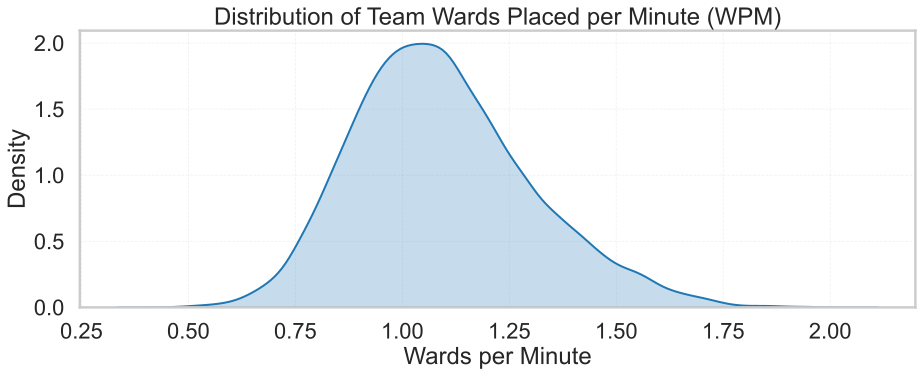

In [199]:
plt.figure(figsize=(15, 5))
sns.kdeplot(grouped['wpm'], fill=True)
plt.title("Distribution of Team Wards Placed per Minute (WPM)")
plt.xlabel("Wards per Minute")
plt.ylabel("Density")
plt.grid(visible=True, linestyle='--', linewidth=0.8, alpha=0.3)
plt.show()

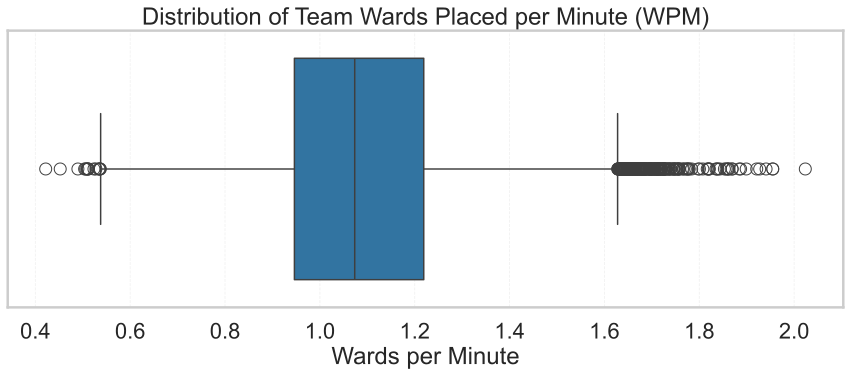

In [200]:
plt.figure(figsize=(15, 5))
sns.boxplot(x=grouped['wpm'], linewidth=1.5)
plt.title("Distribution of Team Wards Placed per Minute (WPM)")
plt.xlabel("Wards per Minute")
plt.yticks([])
plt.grid(visible=True, linestyle='--', linewidth=0.8, alpha=0.3)
plt.show()

Now, let's see if there is a glaring difference at first sight between the wdm of teams that won, and the wdm of teams that lost.

In [201]:
wpm_win = grouped[grouped['result'] == 1]['wpm']
wpm_loss = grouped[grouped['result'] == 0]['wpm']

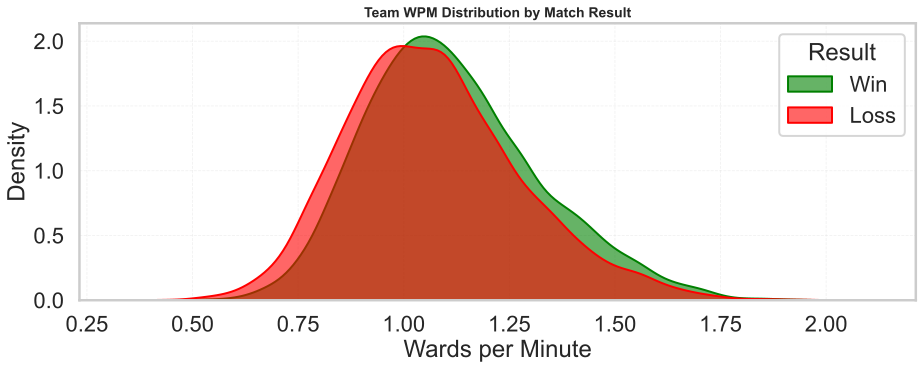

In [202]:
plt.figure(figsize=(15, 5))

sns.kdeplot(wpm_win, fill=True, label='Win', color='green', alpha=0.6, linewidth=2)
sns.kdeplot(wpm_loss, fill=True, label='Loss', color='red', alpha=0.6, linewidth=2)

plt.title("Team WPM Distribution by Match Result", fontsize=14, fontweight='bold')
plt.xlabel("Wards per Minute")
plt.ylabel("Density")
plt.grid(visible=True, linestyle='--', linewidth=0.8, alpha=0.3)
plt.legend(title="Result", loc="upper right")
plt.show()

As for the boxplot, we need to add an extra column called result_str, because Seaborne expects the palette keys to exactly match the unique values in the y='result' column, and if they don’t, it raises a ValueError. To prevent possible errors, we will make this new column and map it to the boxplot.

C:\Users\Jacob Doan\AppData\Local\Temp\ipykernel_4888\585939008.py:18: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



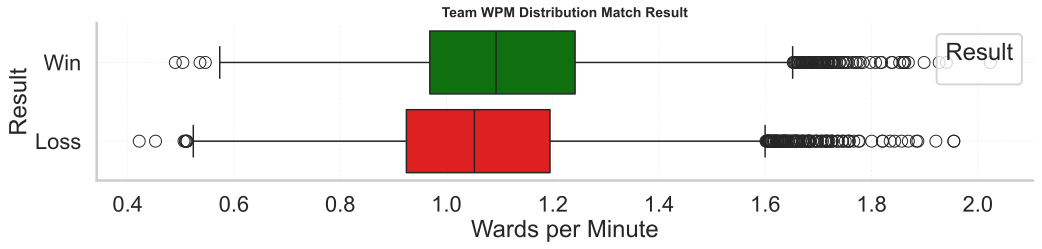

In [203]:
grouped['result_str'] = grouped['result'].map({1: 'Win', 0: 'Loss'})

plt.figure(figsize=(15, 4))

sns.boxplot(
    data=grouped,
    x='wpm',
    y='result_str',
    hue='result_str',
    palette={'Win': 'green', 'Loss': 'red'},
    linewidth=1.5,
    dodge=False
)

plt.title("Team WPM Distribution Match Result", fontsize=14, fontweight='bold')
plt.xlabel("Wards per Minute")
plt.ylabel("Result")
plt.legend(title='Result', loc='upper right')
plt.grid(visible=True, linestyle='--', linewidth=0.8, alpha=0.3)
sns.despine()
plt.tight_layout()
plt.show()

Before we continue, let's change the variable name of our dataframe to `wards_df` because it sounds more meaningful than `grouped`. We will refer to `wards_df` from this point on.

In [204]:
wards_df = grouped
wards_df

,gameid,teamid,wpm,result,result_str
0,10660-10660_game_1,oe:team:8516ca63facc91286d6c00212ca945e,1.29,1,Win
1,10660-10660_game_1,oe:team:a9145b7711873f53e610fbba0493484,1.03,0,Loss
2,10660-10660_game_2,oe:team:8516ca63facc91286d6c00212ca945e,1.21,1,Win
...,...,...,...,...,...
19153,LOLTMNT99_148130,oe:team:5203ff881d5c82c5f720eb3a2f3b44c,0.97,1,Win
19154,LOLTMNT99_148194,oe:team:1bcba9d314932379a955b3de9e8654d,1.34,0,Loss
19155,LOLTMNT99_148194,oe:team:28428f3022fc1ea52264b35912093dc,1.21,1,Win


## Step 3: Assessment of Missingness

When we initially created the `ward_df` DataFrame (previously referred to as `grouped`), we made a critical design choice during aggregation: we excluded rows with missing values in teamid. Our reasoning at the time was practical: including incomplete team data could distort the distributions of key metrics like wards placed per minute (wpm) or match outcomes (result). For example, if a team disconnected mid-match or was partially recorded, its statistics might not reflect actual gameplay and could **introduce noise or bias** into our analysis.

However, this decision raises an important question: **was the missingness of teamid random, or was it systematically related to other variables in our dataset?** If it was not random (NMAR), then excluding those rows — even for good reasons — could unintentionally bias our results, since there is probably a good reason why those team ids are missing that we haven't seen clearly yet. 

In our earlier cleaning steps, we focused on ensuring that quantitative columns like wpm, result, and wardsplaced contained no missing values. We did not yet explore missingness in columns as `gameid`, `playerid`, and `teamid`, because of their irrelevance to aggregating the data at the time. Now, as we transition to a deeper analysis of missing data, we will revisit the full `relevant_df` and `df` to formally investigate the missingness mechanisms behind `teamid` and how they might affect our conclusions.

In [217]:
relevant_df.isnull().sum()

gameid             0
playerid       20660
teamid          2712
wardsplaced        0
gamelength         0
wpm                0
result             0
dtype: int64

It seems like only `playerid` and `teamid` has missing values. Let's analyze `playerid` first before we move on.

At first glance, the column `playerid` appears to be Not Missing At Random (NMAR). There are several reasons to suspect this.

First, there are many more missing `playerid` values than there are missing `teamid` values. So implies that `playerid` can be **missing independently of `teamid`** — which is important context. Moreover, many rows with missing `playerid` still contain a valid `teamid` and complete gameplay statistics — such as `wardsplaced`, `wpm`, and `result`. This suggests that the missingness is not tied to overall data corruption completely, but rather it could be to the identity of the player itself.

**Without additional context**, it seems the missingness can be tied to the player's identity itself. Examples that could explain this could be due to data privacy settings, untracked players, or deleted accounts. These are unobservable from within the dataset, which fits the definition of NMAR.

However, it is important to note that we are only basing our conclusion given only the column context within `wards_df`. If we were to incorporate broader metadata from the full dataset, such as datacompleteness, league, or split, we might find patterns that explain the missingness of `playerid`. For example, matches flagged as "partial" in the column `datacompleteness` may be systematically missing player identity information. In that case, the missingness could be modeled by observed variables, and `playerid` would instead be considered Missing At Random (MAR).

Thus, our conclusion is that `playerid` is NMAR without additional context outside of `relevant_df`, but it could be MAR when we incorporate metadata from the full dataset.

Next, we will explore the missingness of `teamid`.

Unlike playerid, `teamid` is central to our primary research question: how **team-level statistics** like wpm relate to winning. This makes its missingness more **consequential** — if rows with missing teamid differ systematically, their exclusion could bias our analysis. In other words, it really doesn't matter what type of missingness `playerid` has, since the objective of our main analysis does not care for it. That column was only supposed to give us a visual representation of how each team has multiple rows of data that needed to be aggregated into. The more imporant column of interst is `teamid`

While teamid also has missing values in **relevant_df**, we realized that to properly investigate its missingness mechanism, we needed to go beyond **relevant_df**. Many of the variables such as match-level metadata like `datacompleteness` were likely to explain its absence. Othe arbitrary gameplay statistics like `earnedgpm` could also be analyzed in context too, but these columns were only available in the original full dataset (df).

Therefore, we extended our analysis and performed permutation tests using variables from the full dataset. Our goal was to determine whether the missingness of `teamid` is Missing Completely At Random (MCAR), Missing At Random (MAR), or potentially NMAR. If the missingness can be explained by known columns, it would support a MAR classification and justify our earlier decision to drop rows with missing teamid in `wards_df` (aka `grouped`). If not, we would need to re-evaluate our cleaning pipeline.

The following permutation tests evaluate whether `teamid` missingness depends on observed columns.

Our hypothesis is that `teamid` is Missing At Random (MAR), because it would justify our decision to remove those missing rows. To test this, we examined whether the missingness of teamid depends on:

- Another column in `df` that should be related (like `datacompleteness`, since if the data is only partially complete is missing, we might expect teamid to be incomplete)

- Another column in `df` that should not be related (like earnedgpm, since earned gold per minute shouldn't logically influence whether a team's name is recorded or not)

We conducted permutation tests to investigate whether the distributions of these variables change depending on whether teamid is missing or not. Below, we present and interpret our results. We set our alpha threshold at standard 0.05.

**Note: We have to be careful on which columns we select to test!** If the column we are testing against also has missing values that overlap with teamid, then our permutation test can give artificially low p-values, not because there's a true association. This is because both columns could be missing in the same rows. We can  find which columns to pick using code.

In [218]:
# Here, we manually picked which columns without missing data might be good to compare against in a permutation test
df.isnull().sum()[df.isnull().sum() <= 0]

gameid              0
datacompleteness    0
league              0
                   ..
earned gpm          0
goldspent           0
monsterkills        0
Length: 35, dtype: int64

In [219]:
relevant_df_copy = relevant_df.copy()

relevant_df_copy['teamid_missing'] = relevant_df_copy['teamid'].isnull()
relevant_df_copy['playerid_missing'] = relevant_df_copy['playerid'].isnull()

relevant_df_copy

,gameid,playerid,teamid,wardsplaced,...,wpm,result,teamid_missing,playerid_missing
0,10660-10660_game_1,oe:player:65ed20b21e2993fb00dbd21a2fd991b,oe:team:a9145b7711873f53e610fbba0493484,14,...,0.45,0,False,False
1,10660-10660_game_1,oe:player:57da8dfcfbdb4e5b019fe93003db1c4,oe:team:a9145b7711873f53e610fbba0493484,10,...,0.32,0,False,False
2,10660-10660_game_1,oe:player:71e79ef80600d398d90cfebe3b0b758,oe:team:a9145b7711873f53e610fbba0493484,4,...,0.13,0,False,False
...,...,...,...,...,...,...,...,...,...
117645,LOLTMNT02_194401,oe:player:3126bca5d4d2555ba3b460699508e16,oe:team:66eccb6faca7fd5e3cdf4ccf903385c,81,...,1.91,1,False,False
117646,LOLTMNT02_194401,NaN,oe:team:2a247555001e6364757f171f158f997,146,...,3.44,0,False,True
117647,LOLTMNT02_194401,NaN,oe:team:66eccb6faca7fd5e3cdf4ccf903385c,158,...,3.72,1,False,True


In [220]:
# it seems about 2.3% of our teamid column has missing values
relevant_df_copy['teamid_missing'] = relevant_df_copy['teamid'].isnull()
relevant_df_copy['teamid_missing'].value_counts()

teamid_missing
False    114936
True       2712
Name: count, dtype: int64

Now, let's start the permutation tests for `earned gpm` and `datacompleteness`

In [221]:
relevant_df_copy['earned gpm'] = df['earned gpm']

# Setting up observed difference
obs_diff_gpm_df = relevant_df_copy.groupby('teamid_missing')['earned gpm'].mean()

obs_diff_gpm = obs_diff_gpm_df.loc[True] - obs_diff_gpm_df.loc[False]

# Permutation test
n_reps = 1000
diffs = []

for _ in range(n_reps):
    shuffled = np.random.permutation(relevant_df_copy['teamid_missing'])
    shuffled_df = relevant_df_copy.assign(shuffled_wpm=shuffled)
    
    group_means = shuffled_df.groupby('shuffled_wpm')['earned gpm'].mean()
    diff = group_means.loc[True] - group_means.loc[False]
    diffs.append(diff)

# Plot results
fig = go.Figure()
fig.add_trace(go.Histogram(x=diffs, nbinsx=50, name='Permuted Differences'))
fig.add_vline(x=obs_diff_gpm, line_color='red', line_width=2, opacity=1)
fig.update_layout(
    title='Permutation Test: Earned GPM vs. TeamID Missingness',
    xaxis_title='Difference in Mean Earned GPM',
    yaxis_title='Frequency'
)
fig.show()

# Two-sided p-value
p_val = np.mean(np.abs(diffs) >= np.abs(obs_diff_gpm))
print(f"P-value: {p_val:.4f}")

P-value: 0.0930


In [222]:
relevant_df_copy['datacomplete_binary'] = df['datacompleteness'].map({'complete': 0, 'partial': 1})

# Setting up observed difference
obs_diff_complete_df = relevant_df_copy.groupby('teamid_missing')['datacomplete_binary'].mean()

obs_diff_complete = obs_diff_complete_df.loc[True] - obs_diff_complete_df.loc[False]

# Permutation test
n_reps = 1000
diffs = []

for _ in range(n_reps):
    shuffled = np.random.permutation(relevant_df_copy['teamid_missing'])
    shuffled_df = relevant_df_copy.assign(shuffled_wpm=shuffled)
    
    group_means = shuffled_df.groupby('shuffled_wpm')['datacomplete_binary'].mean()
    diff = group_means.loc[True] - group_means.loc[False]
    diffs.append(diff)

# Plot results
fig = go.Figure()
fig.add_trace(go.Histogram(x=diffs, nbinsx=50, name='Permuted Differences'))
fig.add_vline(x=obs_diff_complete, line_color='red', line_width=2, opacity=1)
fig.update_layout(
    title='Permutation Test: Data Completeness vs. TeamID Missingness',
    xaxis_title='Difference in Mean Data Completeness',
    yaxis_title='Frequency'
)
fig.show()

# Two-sided p-value
p_val = np.mean(np.abs(diffs) >= np.abs(obs_diff_complete))
print(f"P-value: {p_val:.4f}")

P-value: 0.0000


After running our permutation tests:

The p-value for `earnedgpm` was above 0.05, which is not statistically significant at α = 0.05, suggesting we found at least one column without a meaningful relationship between missingness of teamid and gold earned per minute. This is a gameplay statistic unrelated to data collection quality.

The p-value for `datacompleteness` was below 0.05, indicating a strong relationship between whether a row has a missing teamid and whether the match was flagged as "complete" or "partial."

These results rule out MCAR (Missing Completely At Random) for `teamid`, because at least one observed column (`datacompleteness`) does explain the missingness. This supports the interpretation that teamid is Missing At Random (MAR). The probability of teamid being missing is highly related to other observed variables in the dataset (like metadata about match completeness), but not to unobservable factors.

Since the missingness is explainable by observed data, we can conclude that `teamid` does not have an NMAR missingness mechanism, and thus our earlier choice to drop rows with missing teamid is justified. Doing so likely does not introduce bias into our core analysis of WPM vs. win rate, because the mechanism driving the missingness is not related to the values of the statistics we're analyzing (like `earnedgpm` or `wpm`), but to data quality flags.

In contrast, we cannot make the same claim for `playerid` (as discussed previously), which may be NMAR due to factors that are not observable in the current context (`relevant_df`). Fortunately, since playerid is not central to our analysis, this does not impact the validity of our conclusions.

## Step 4: Hypothesis Testing

In [24]:
mean_win = grouped[grouped['result'] == 1]['wpm'].mean()
mean_loss = grouped[grouped['result'] == 0]['wpm'].mean()
obs_diff = mean_win - mean_loss

print("Mean WPM (Win):", mean_win)
print("Mean WPM (Loss):", mean_loss)
print("Observed Difference:", obs_diff)

Mean WPM (Win): 1.1160762595287594
Mean WPM (Loss): 1.070521721196868
Observed Difference: 0.04555453833189138


In [25]:
n_permutations = 1000
diffs = []

# Permute results and recalculate difference
for _ in range(n_permutations):
    shuffled_result = grouped['result'].sample(frac=1, replace=False).reset_index(drop=True)
    shuffled_win_mean = grouped[shuffled_result == 1]['wpm'].mean()
    shuffled_loss_mean = grouped[shuffled_result == 0]['wpm'].mean()
    diffs.append(shuffled_win_mean - shuffled_loss_mean)

# Calculate p-value
p_value = np.mean(np.abs(diffs) >= np.abs(obs_diff))

print("Permutation p-value:", p_value)

Permutation p-value: 0.0


## Step 5: Framing a Prediction Problem

In [ ]:
# TODO

## Step 6: Baseline Model

In [ ]:
# TODO

## Step 7: Final Model

In [ ]:
# TODO

## Step 8: Fairness Analysis

In [ ]:
# TODO